<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2021/blob/main/01_Intro_to_NN_Pytorch/Week1_Intro_to_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown -qqq
!pip install pytorch-lightning -qqq
!pip install wandb -qqq

In [ ]:
!gdown --id 1U1AHtJW54coNyRBQPIuKQd0eBb2ErU2H

Downloading...
From: https://drive.google.com/uc?id=1U1AHtJW54coNyRBQPIuKQd0eBb2ErU2H
To: /content/Churn_Modelling.csv
100% 685k/685k [00:00<00:00, 60.0MB/s]


#Neural Network basics

## Given a Bank customer, can we build a classifier which can determine whether they will leave or not using Neural networks?
The case study is from an open source dataset from Kaggle.

Link to the Kaggle project site:
https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

In [ ]:
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

In [ ]:
ds = pd.read_csv("Churn_Modelling.csv")

In [ ]:
ds.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [ ]:
ds['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

### RowNumber, CustomerId, and Surname are unique hence we are dropping it

In [ ]:
ds = ds.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Distinguish the feature and target set

In [ ]:
X = ds.iloc[:,0:10].values # Credit Score through Estimated Salary
y = ds.iloc[:,10].values # Exited

### Encoding categorical (string based) data. Country: there are 3 options: France, Spain and Germany. This will convert those strings into scalar values for analysis.

In [ ]:
print(X[:8,1], '... will now become: ')

label_X_country_encoder = LabelEncoder()
X[:,1] = label_X_country_encoder.fit_transform(X[:,1])
print(X[:8,1])

['France' 'Spain' 'France' 'France' 'Spain' 'Spain' 'France' 'Germany'] ... will now become: 
[0 2 0 0 2 2 0 1]


### We will do the same thing for gender. this will be binary in this dataset

In [ ]:
print(X[:6,2], '... will now become: ')

label_X_gender_encoder = LabelEncoder()
X[:,2] = label_X_gender_encoder.fit_transform(X[:,2])
print(X[:6,2])

['Female' 'Female' 'Female' 'Female' 'Female' 'Male'] ... will now become: 
[0 0 0 0 0 1]


### The Problem here is that we are treating the countries as one variable with ordinal values (0 < 1 < 2). Therefore, one way to get rid of that problem is to split the countries into respective dimensions. Gender does not need this as it is binary

### Converting the string features into their own dimensions. Gender doesn't matter here because its binary

In [ ]:
from sklearn.compose import ColumnTransformer 
country = ColumnTransformer([("transform_country", OneHotEncoder(), [1])], remainder = 'passthrough')
X = country.fit_transform(X)#.toarray()

In [ ]:
X.shape

(10000, 12)

In [ ]:
X

array([[1.0, 0.0, 0.0, ..., 1, 1, 101348.88],
       [0.0, 0.0, 1.0, ..., 0, 1, 112542.58],
       [1.0, 0.0, 0.0, ..., 1, 0, 113931.57],
       ...,
       [1.0, 0.0, 0.0, ..., 0, 1, 42085.58],
       [0.0, 1.0, 0.0, ..., 1, 0, 92888.52],
       [1.0, 0.0, 0.0, ..., 1, 0, 38190.78]], dtype=object)

In [ ]:
# A 0 on two countries means that the country has to be the one variable which wasn't included 
# This will save us from the problem of using too many dimensions
X = X[:,1:] # Got rid of Spain as a dimension.

### Divide the data set into Train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

### Normalize the train and test data

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_test.shape

(2000, 11)

### Initialize & build the model

In [ ]:
from sklearn.metrics import accuracy_score

import numpy as np
import torch
from torch import nn
from torch import sigmoid
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import WandbLogger

In [ ]:
!wandb login f0ec70da847783160066976cd7aa3b6c64cb1007

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
train_loader=DataLoader(TensorDataset(torch.from_numpy(X_train.astype(np.float32)),
                                        torch.from_numpy(y_train.astype(np.float32))), 
                          batch_size=64)
val_loader=DataLoader(TensorDataset(torch.from_numpy(X_train.astype(np.float32)),
                                        torch.from_numpy(y_train.astype(np.float32))), 
                          batch_size=64)

In [ ]:
class LitMNIST(LightningModule):
  def __init__(self, optim, loss=nn.MSELoss(), lr=1e-3, batch_size=64):
    super().__init__()
    self.batch_size = batch_size
    self.optim=optim
    self.loss=loss
    self.lr=lr

    # Hardcoding
    self.hidden = 6
    self.input_dim = 11

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.input_dim, self.hidden),
        nn.ReLU(),
        nn.Linear(self.hidden, self.hidden),
        nn.Sigmoid(),
        nn.Linear(self.hidden, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.model(x)
    return (x)

  def configure_optimizers(self):
        return self.optim(self.parameters(), lr=self.lr)

  def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.loss(logits, y)
        result= pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        return result

  def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.loss(logits, y)
        preds=(logits>0.5)== y
        acc = preds.float().mean()
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, prog_bar=True,on_epoch=True, on_step=False)
        result.log('val_acc', acc, prog_bar=True,on_epoch=True, on_step=False)
        return result


## Training the model

In [ ]:
wandb_logger = WandbLogger(name='SGD-64-0.001',project='pytorchlightning')
model = LitMNIST(optim=torch.optim.SGD, loss=nn.BCELoss(), lr=1e-3)
trainer = pl.Trainer(max_epochs=100, progress_bar_refresh_rate=0, gpus=1, logger=wandb_logger)
trainer.fit(model,train_loader,val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


global_step,12499
train_loss,0.28308
epoch,99
_step,299
_runtime,46
_timestamp,1601910589
val_loss,0.28155
val_acc,0.204


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁



  | Name  | Type       | Params
-------------------------------------
0 | loss  | BCELoss    | 0     
1 | model | Sequential | 121   
Saving latest checkpoint..


1

### Optimize the model
Some important parameters to look out for while optimizing neural networks are:

-Type of architecture

-Number of Layers

-Number of Neurons in a layer

-Regularization parameters

-Learning Rate

-Type of optimization / backpropagation technique to use

-Dropout rate

-Weight sharing

#### Number of Layers:
We will keep it similar to the above model so that we can compare the accuracy.
1 hidden layer.

#### Activation:
input layer: relu becasue we are in an input layer. uses the ReLu activation function for  ϕ

output layer: sigmoid becasue we are in an output layer. uses the Sigmoid activation function for  ϕ . This is used instead of the ReLu function becasue it generates probabilities for the outcome. We want the probability that each customer leaves the bank.

#### Type of optimization / backpropagation technique to use: 
We will use Adam. Adam is a very efficient variation of Stochastic Gradient Descent. For Adam and its variant, learning rate or the decay rate does not really matter too much.

#### Learning Rate:
default learning rate 0.001.

#### Number of Neurons in a layer:
We will keep it 6 as per our initial calculation above.

#### Weight sharing / kernel_initializer: 
Normal distribution with which we randomly initialize weights for the nodes in this layer.

#### Loss:
loss: binary_crossentropy This is the loss function used within adam. This should be the logarthmic loss. If our dependent (output variable) is Binary, it is binary_crossentropy. If Categorical, then it is called categorical_crossentropy

### Rebuilding the model using these optimised parameters

In [ ]:
wandb_logger = WandbLogger(name='Adam-64-0.001',project='pytorchlightning')
model = LitMNIST(optim=torch.optim.Adam, loss=nn.MSELoss(), lr=1e-3)
trainer = pl.Trainer(max_epochs=100, progress_bar_refresh_rate=0, gpus=1, logger= wandb_logger)
trainer.fit(model,train_loader,val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


global_step,12499
train_loss,0.48366
epoch,99
_step,299
_runtime,46
_timestamp,1601910699
val_loss,0.50641
val_acc,0.796


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁



  | Name  | Type       | Params
-------------------------------------
0 | loss  | MSELoss    | 0     
1 | model | Sequential | 121   
Saving latest checkpoint..


1

In [ ]:
import base64
encoded = base64.b64encode(open("wandb.png", "rb").read())
encoded

b'iVBORw0KGgoAAAANSUhEUgAABz8AAANHCAIAAAAnnwc6AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P15UFTp3i967jPce0+f3XHfc/r26eiIN6LPjdj9X/eJeyPe20a0tlW7PLVfa5dWbcuatLRwKLXUVBTElEERRVEUtYBknud5FhFkEGRSBBkEZR5kUAFFUiCZpJ+V68lFkkyZ+WQuMsnvJ55g5xpyAdbml7/88vCsP82Zm9bWVvoIAEwb+WmdBAAAAAAAAAAAfSG9BQBjQXoLAAAAAAAAAMAC6S0AGAvSWwAAAAAAAAAAFkhvAcBYkN4CAAAAAAAAALBAegsAxoL0FgAAAAAAAACABdJbADAWpLcAAAAAAAAAACyQ3gKAsSC9BQAAAAAAAABggfQWAIwF6S0AAAAAAAAAAAuktwBgLEhvAQAAAAAAAABYsKa3n5ToxjK0OUd7SG8BzAXSWwAAAAAAAAAAFkzprZDJKhSKvr6+ysrK/Pz8tLS09PR08oBskp3kEH+OoQJcpLcA5gLpLQAAAAAAAAAAC9a5t6Ojo8XFxdHR0UFBQenp6Q8ePKhUIg/IJtlJDpWUlMjlcvoEZkhvAcwF0lsAAAAAAAAAABZM6W11dXVISEhiYmJTU9PHjx81ZteSTbKTHCInkNPIyfQAG6S3AOYC6S0AAAAAAAAAAAud01s+olUoFHfv3g0JCWlqauL3C8gJ/DnqyGnkZPIUfiGFxSdoD+ktgLlAegsAAAAAAAAAwEKfubfkaYmJibGxsSMjI/wejTRWmd/SPcIDcjJ5CnkieTq/Rz9IbwHMBdJbAAAAAAAAAAAWuqW3fBSbnZ0dFxfHz6KdnZ0V8lmexiZB9pDTyAPyFPJE8nR+p/KgzpDeApgLpLcAAAAAAAAAACx0SG/5vLW6ujo4OHh0dFTYIyCb/J6urq7BwUF+j/IIh3

### Sample output from Weights & Biases

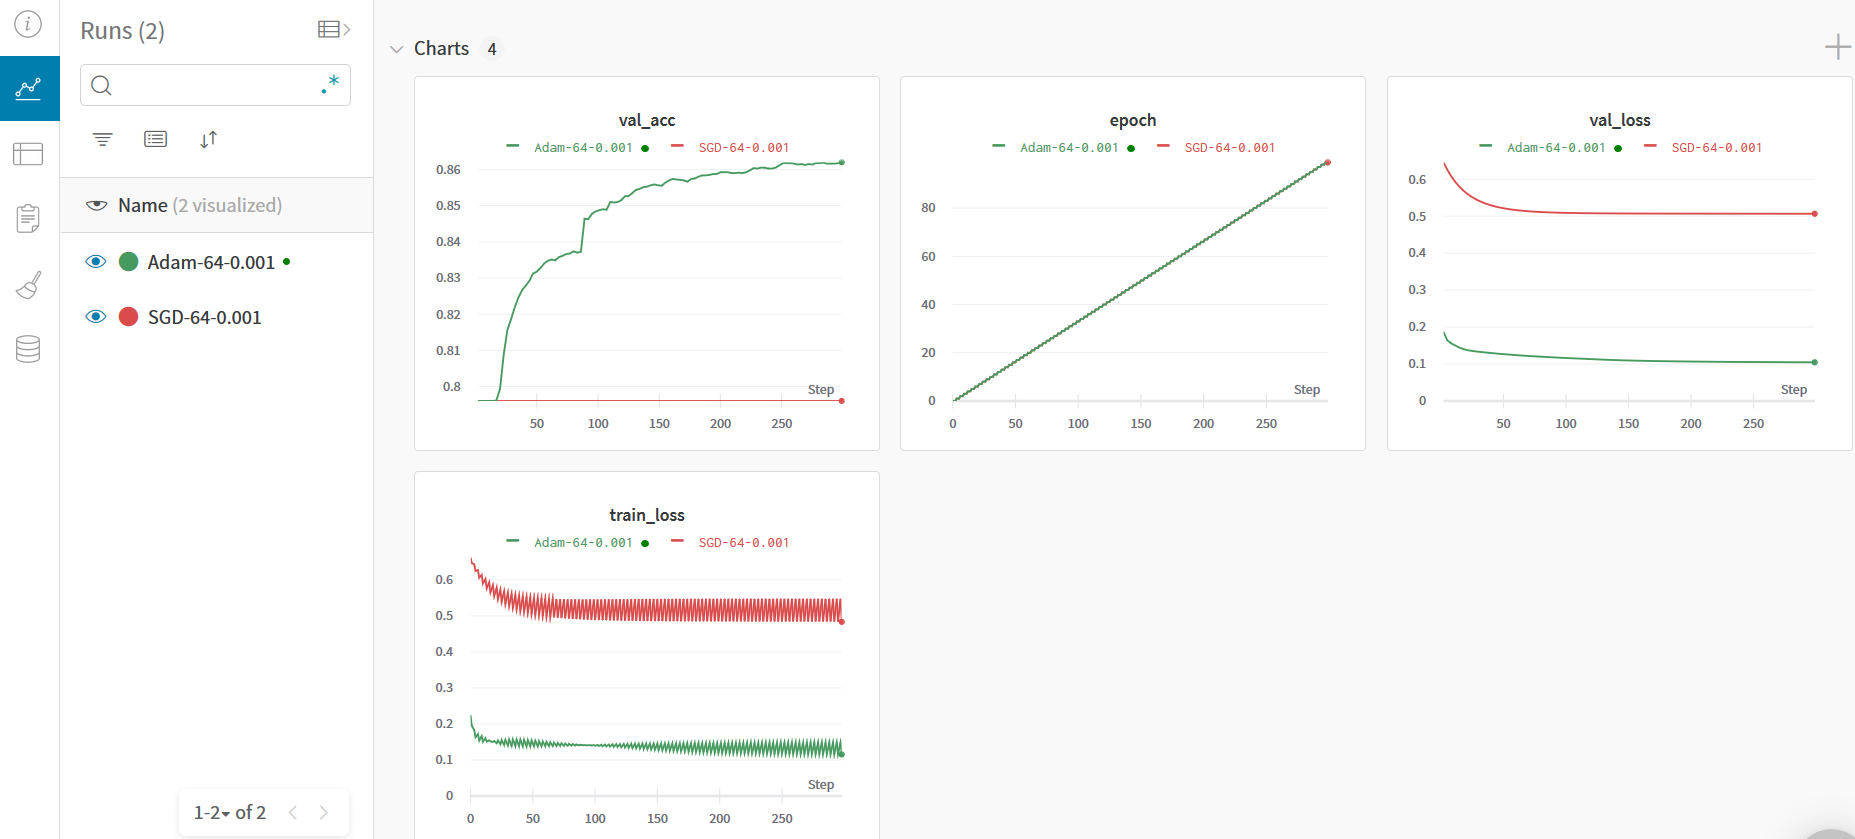

## Inference

In [ ]:
!find . -name "*.ckpt"

./pytorchlightning/2hlkpqe7/checkpoints/epoch=99.ckpt
./pytorchlightning/1pb9c1om/checkpoints/epoch=99.ckpt
./pytorchlightning/qvzbdpxa/checkpoints/epoch=99.ckpt
./pytorchlightning/2dkk75ix/checkpoints/epoch=99.ckpt
./pytorchlightning/2v88qji2/checkpoints/epoch=99.ckpt
./pytorchlightning/2w3co7zd/checkpoints/epoch=92.ckpt
./pytorchlightning/6a0g0wae/checkpoints/epoch=99.ckpt


In [ ]:
model = LitMNIST.load_from_checkpoint('./pytorchlightning/6a0g0wae/checkpoints/epoch=99.ckpt')
device = torch.device("cuda:0")

In [ ]:
def predict(model, dataloader, n_class, device):
    model.eval()
    model.to(device)
    preds = np.zeros([0, n_class])
    for data, _ in dataloader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data).detach()
        y_pred = y_pred.cpu().numpy()
        preds = np.concatenate([preds, y_pred])
    return preds

In [ ]:
val_preds = predict(model, val_loader, n_class=1, device=device)
preds=(val_preds>0.5).astype(float)
val_acc = accuracy_score(y_train, preds)
print(f'val acc: {val_acc}')

val acc: 0.8655
